In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from torch import optim
import torch
from torch import nn
import pandas as pd
from tqdm.notebook import tqdm
from torch.nn.utils.rnn import pack_sequence
from torch.nn.utils.rnn import pad_packed_sequence
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, Dataset, TensorDataset
from torch.autograd import Variable
from torch.optim.lr_scheduler import StepLR
from sklearn.metrics import mean_absolute_percentage_error
from IPython.display import clear_output
%matplotlib inline

In [2]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(LSTM, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.gate_size = 4 * self.hidden_size
        
        self.W_i = nn.Parameter(torch.Tensor(input_size, self.gate_size).zero_())
        
        self.W_h = nn.Parameter(torch.Tensor(hidden_size, self.gate_size).zero_())
        
        self.b = nn.Parameter(torch.Tensor(self.gate_size).zero_())
        
        
    def forward(self, inputs, hidden):
        if hidden is None:
            h = Variable(torch.zeros(self.hidden_size, inputs.size(0)), requires_grad=False)
            c = Variable(torch.zeros(self.hidden_size, inputs.size(0)), requires_grad=False)
        else:
            h, c = hidden
        bs = h.size(0)
        h, c = hidden
        bs = h.size(0)
        
        seq_length = inputs.size(0)
        out = Variable(torch.Tensor(seq_length, bs, self.hidden_size))
        
        for i, inp in enumerate(inputs):
            S = (torch.matmul(inp, self.W_i) + torch.matmul(h, self.W_h) + self.b)
            S = S.view(bs, 4, self.hidden_size)
            
            i_1 = torch.sigmoid(S[:,0,:])
            f_1 = torch.sigmoid(S[:,1,:])
            g_1 = torch.tanh(S[:,2,:])
            o_1 = torch.sigmoid(S[:,3,:])
            
            c = f_1 * c + i_1 * g_1
            h = o_1 * torch.tanh(c)
            out[i] = h
        return out, (h, c)

In [3]:
df = pd.read_csv("train.csv", sep=',')

In [4]:
df.head()

,date,hits
0,2016-01-01,201979088
1,2016-01-02,223095158
2,2016-01-03,233791442
3,2016-01-04,259684220
4,2016-01-05,267112490


In [5]:
hits = df.hits.values
date = df.date.values

## Разбираемся с train

In [6]:
test_date = date[date>='2018-01-01']

In [7]:
hits = hits.reshape(-1, 1)

In [8]:
hits = hits.astype('float32')
train_hits = hits

In [9]:
scaler = MinMaxScaler(feature_range=(0, 1))
train_data = scaler.fit_transform(train_hits)

In [10]:
train_data.shape

(1096, 1)

In [11]:
# разбиваем данные на train / valid
train_size = int(train_data.shape[0] * 0.92)
valid_size = train_data.shape[0] - train_size
train, valid = train_data[0:train_size,:], train_data[train_size:train_data.shape[0],:]
print(len(train), len(valid))

1008 88


In [12]:
def create_dataset(dataset, look_back=1, look_forward=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1-look_forward):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back : (i + look_back + look_forward), 0])

    return np.array(dataX), np.array(dataY)

In [13]:
look_back = 70
look_forward = 1
trainX, trainY = create_dataset(train, look_back, look_forward)
validX, validY = create_dataset(valid, look_back, look_forward)

In [14]:
trainX.shape

(936, 70)

In [15]:
validX.shape

(16, 70)

In [16]:
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))

In [17]:
validX = np.reshape(validX, (validX.shape[0], 1, validX.shape[1]))

In [18]:
train_dataset = TensorDataset(torch.from_numpy(trainX), torch.from_numpy(trainY))

In [19]:
train_dataloader = DataLoader(train_dataset, batch_size=5)

In [20]:
valid_dataset = TensorDataset(torch.from_numpy(validX), torch.from_numpy(validY))

In [21]:
valid_dataloader = DataLoader(valid_dataset, batch_size=5)

## Models

In [22]:
class CNN_with_lstm(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(CNN_with_lstm, self).__init__()
        self.hidden_size = hidden_dim
        self.lstm = LSTM(input_dim, hidden_dim)
        self.linear = nn.Sequential(nn.Linear(hidden_dim, 256), nn.ReLU())
        self.conv_layer = nn.Sequential(nn.Conv2d(1, 32, 4, 2, 1),
                                       nn.ReLU(),
                                       nn.Conv2d(32, 64, 4, 2, 1),
                                       nn.ReLU(),
                                       nn.MaxPool2d(4, 2, 1),
                                       nn.ReLU())
        self.linear_out = nn.Linear(64 * 2 * 2, output_dim)

    def forward(self, X, hidden):
        output_lstm, _ = self.lstm(X, hidden)
        output_lstm = output_lstm.view(X.shape[0], -1)
        output1 = self.linear(output_lstm)
        output1 = output1.view(X.shape[0], 1, 16, 16)
        output_cnn = self.conv_layer(output1)
        output_cnn = output_cnn.view(X.shape[0], -1)
        output = self.linear_out(output_cnn)

        return output

In [23]:
class CNN_with_torch_lstm(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(CNN_with_torch_lstm, self).__init__()
        self.hidden_size = hidden_dim
        self.lstm = nn.LSTM(input_dim, hidden_dim)
        self.linear = nn.Sequential(nn.Linear(hidden_dim, 256), nn.ReLU())
        self.conv_layer = nn.Sequential(nn.Conv2d(1, 32, 4, 2, 1),
                                       nn.ReLU(),
                                       nn.Conv2d(32, 64, 4, 2, 1),
                                       nn.ReLU(),
                                       nn.MaxPool2d(4, 2, 1),
                                       nn.ReLU())
        self.linear_out = nn.Linear(64 * 2 * 2, output_dim)

    def forward(self, X, hidden):
        output_lstm, _ = self.lstm(X)
        output_lstm = output_lstm.view(X.shape[0], -1)
        output1 = self.linear(output_lstm)
        output1 = output1.view(X.shape[0], 1, 16, 16)
        output_cnn = self.conv_layer(output1)
        output_cnn = output_cnn.view(X.shape[0], -1)
        output = self.linear_out(output_cnn)

        return output

In [24]:
class Regressor_with_linear(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(Regressor_with_linear, self).__init__()
        self.hidden_size = hidden_dim
        self.lstm = LSTM(input_dim, hidden_dim)
        self.linear = nn.Sequential(nn.Linear(hidden_dim, output_dim))

    def forward(self, X, hidden):
        output, _ = self.lstm(X, hidden)
        output = output.view(X.shape[0], -1)
        output = self.linear(output)
        return output

In [25]:
class Regressor_lstm(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(Regressor_lstm, self).__init__()
        self.hidden_size = hidden_dim
        self.lstm = LSTM(input_dim, hidden_dim)

    def forward(self, X, hidden):
        output1, _ = self.lstm(X, hidden)
        output = output1.view(X.shape[0], -1)[:,-1]
        output = output.view(-1, 1)
        return output

In [26]:
class Regressor_torch_lstm(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(Regressor_torch_lstm, self).__init__()
        self.hidden_size = hidden_dim
        self.lstm = nn.LSTM(input_dim, hidden_dim)

    def forward(self, X, hidden):
        output1, (self.hn, self.cn) = self.lstm(X)
        output = output1.view(X.shape[0], -1)[:,-1]
        output = output.view(-1, 1)
        return output

In [27]:
hidden_size = 100
output_dim = 1
model = CNN_with_torch_lstm(look_back, hidden_size, output_dim)

In [30]:
def _epoch(network, loss, loader, optimizer, device='cpu'):
    losses = []
    for X, y in loader:
        X = X.type(dtype=torch.FloatTensor)
        hidden = (torch.zeros(X.shape[1], network.hidden_size).type(dtype=torch.FloatTensor).to(device),
                        torch.zeros(X.shape[1], network.hidden_size).type(dtype=torch.FloatTensor).to(device))
        X = X.to(device)
        y = y.to(device)
        print(X.shape)
        prediction = network(X, hidden)
        loss_batch = loss(prediction, y)
        losses.append(loss_batch.item())
        optimizer.zero_grad()
        loss_batch.backward()
        optimizer.step()
    return losses


def train(network, train_loader, valid_loader,
          epochs, learning_rate,
          device='cpu'):
    loss = nn.MSELoss()
    optimizer = torch.optim.Adam(network.parameters(), lr=learning_rate)
    train_loss_epochs = []
    test_loss_epochs = []
    network = network.to(device)
    try:
        for epoch in tqdm(range(epochs)):
            network.train()
            losses = _epoch(network,
                                        loss,
                                        train_loader,
                                        optimizer,
                                        device)
            train_loss_epochs.append(np.mean(losses))
            
            network.eval()
            losses = _epoch(network,
                                        loss,
                                        valid_loader,
                                        optimizer,
                                        device)

            test_loss_epochs.append(np.mean(losses))
            clear_output(True)
            print('Epoch {0}... (Train/Valid) MSE: {1:.3f}/{2:.3f}'.format(
                        epoch, train_loss_epochs[-1], test_loss_epochs[-1]))
            plt.figure(figsize=(12, 5))
            plt.subplot(1, 2, 1)
            plt.plot(train_loss_epochs, label='Train')
            plt.plot(test_loss_epochs, label='Valid')
            plt.xlabel('Epochs', fontsize=16)
            plt.ylabel('Loss', fontsize=16)
            plt.legend(loc=0, fontsize=16)
            plt.grid()
            plt.show()
    except KeyboardInterrupt:
        if tolerate_keyboard_interrupt:
            pass
        else:
            raise KeyboardInterrupt
    return train_loss_epochs, \
           test_loss_epochs, 

In [31]:
train(model, train_dataloader, valid_dataloader, 70, 0.001)

  0%|          | 0/70 [00:00<?, ?it/s]

torch.Size([5, 1, 70])


RuntimeError: input.size(-1) must be equal to input_size. Expected 1, got 70

На валидации скор постоянно падает при look_back <= 70. Больше 75 уже начинается переобучение сильнее

Look_forward = 1. Самый оптимальный, при других значениях скор на валидации не падает

## Обучим модель на всех train данных

In [1092]:
trainX, trainY = create_dataset(train_data, look_back, look_forward)

In [1093]:
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))

In [1094]:
train_dataset = TensorDataset(torch.from_numpy(trainX), torch.from_numpy(trainY))

In [1095]:
train_dataloader = DataLoader(train_dataset, batch_size=5)

In [1096]:
model = CNN_with_torch_lstm(look_back, hidden_size, output_dim)

In [1097]:
def _epoch(network, loss, loader, optimizer, device='cpu'):
    losses = []
    for X, y in loader:
        X = X.type(dtype=torch.FloatTensor)
        hidden = (torch.zeros(X.shape[1], network.hidden_size).type(dtype=torch.FloatTensor).to(device),
                        torch.zeros(X.shape[1], network.hidden_size).type(dtype=torch.FloatTensor).to(device))
        X = X.to(device)
        y = y.to(device)
        prediction = network(X, hidden)
        loss_batch = loss(prediction, y)
        losses.append(loss_batch.item())
        optimizer.zero_grad()
        loss_batch.backward()
        optimizer.step()
    return losses

def train(network, train_loader, epochs, learning_rate, device='cpu'):
    optimizer = torch.optim.Adam(network.parameters(), lr=learning_rate)
    loss = nn.MSELoss()
    train_loss_epochs = []
    network = network.to(device)
    network = network.train()
    try:
        for epoch in tqdm(range(epochs)):
            losses = _epoch(network, loss, train_loader, optimizer, device)
            train_loss_epochs.append(np.mean(losses))
            clear_output(True)
            print('Epoch {0}... Loss: {1:.3f}'.format(
                        epoch, train_loss_epochs[-1]))
            plt.figure(figsize=(12, 5))
            plt.plot(train_loss_epochs)
            plt.xlabel('Epochs', fontsize=16)
            plt.ylabel('Loss', fontsize=16)
            plt.grid()
            plt.show()
    except KeyboardInterrupt:
        if tolerate_keyboard_interrupt:
            pass
        else:
            raise KeyboardInterrupt
    return train_loss_epochs

Epoch 69... Loss: 0.004


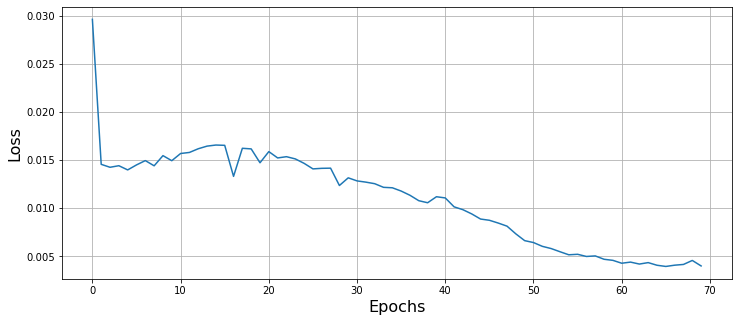

[0.029616606454563713,
 0.014563648022814915,
 0.014258701109225157,
 0.014421330983967025,
 0.013984991828719347,
 0.014503525641907246,
 0.014952546282687008,
 0.014411391371083104,
 0.015466965715650741,
 0.014942894000900772,
 0.01568969050081583,
 0.01579825014632661,
 0.016181950585025067,
 0.016455420948814872,
 0.01656760325443806,
 0.016536840899469808,
 0.01331473803325136,
 0.01623055598124998,
 0.016167326531622832,
 0.014727602648355704,
 0.01588514178292826,
 0.015228349490590938,
 0.015357929812112493,
 0.015127901303995026,
 0.01466576294070564,
 0.01409174391045803,
 0.014150078205545091,
 0.01416635214175075,
 0.012366245637034498,
 0.01316276425254395,
 0.012844007087214112,
 0.01271583588542587,
 0.012554230350964111,
 0.012176395141166101,
 0.012129949949924527,
 0.011790158995888594,
 0.011351149813584392,
 0.01078799769574089,
 0.010576355500748699,
 0.011200191324758456,
 0.011075882402052761,
 0.01015100622050629,
 0.009854598458527684,
 0.009415317034734293,
 

In [1098]:
train(model, train_dataloader, 70, 0.001)

## На трейне скор

In [1099]:
valid_dataloader = DataLoader(train_dataset, batch_size=1)

In [1100]:
def predict_train(network, test_loader, device='cpu'):
    network = network.to(device)
    network.eval()
    predictions = [] 
    
    for X, y in test_loader:
        X = X
        X = X.type(dtype=torch.FloatTensor)
        hidden = (torch.zeros(X.shape[1], network.hidden_size).type(dtype=torch.FloatTensor).to(device),
                        torch.zeros(X.shape[1], network.hidden_size).type(dtype=torch.FloatTensor).to(device))
        X = X.to(device)
        prediction = network(X, hidden)
        predictions.append(prediction)
    return predictions

In [1101]:
train_pred = predict_train(model, valid_dataloader)

In [1102]:
mean_absolute_percentage_error(trainY, train_pred)

/opt/miniconda3/envs/neural-py37/lib/python3.7/site-packages/sklearn/utils/validation.py:63: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  return f(*args, **kwargs)


0.2050685234646848

## Формируем тест

In [1103]:
dates_2019 = []
for date in test_date:
    dates_2019.append('2019' + date[4:])

In [1104]:
test_data = train_data[-look_back:]

In [1105]:
test_data.shape

(70, 1)

In [1106]:
def predict_test(model, test_data, dates_2019, device='cpu'):
    predictions = []
    model = model.to(device)
    model.eval()
    with torch.no_grad():
        for i in range(len(dates_2019)):
            testX = []
            a = test_data[i:i + look_back, 0]
            testX.append(a)
            testX = np.array(testX)
            testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
            # predict
            testX = torch.tensor(testX)
            X = testX.type(dtype=torch.FloatTensor)
            hidden = (torch.zeros(X.shape[1], model.hidden_size).type(dtype=torch.FloatTensor).to(device),
                            torch.zeros(X.shape[1], model.hidden_size).type(dtype=torch.FloatTensor).to(device))
            X = X.to(device)
            prediction = model(X, hidden)
            predictions.append(prediction)
            test_data = np.concatenate((test_data, np.array(prediction).reshape(-1, 1)), axis=0)
    return predictions

In [1107]:
pred = np.array(predict_test(model, test_data, dates_2019)).reshape(-1, 1)

In [1108]:
pred_hits = scaler.inverse_transform(pred)

In [1109]:
pred_hits = pred_hits.flatten()

In [1110]:
pred_hits = pred_hits.astype(int)

In [1111]:
len(pred_hits)

365

In [1112]:
dates = pd.Series(dates_2019)

In [1113]:
hits = pd.Series(pred_hits)

In [1114]:
dictionary = {"date": dates, "hits": hits}

In [1115]:
result_df =  pd.DataFrame(dictionary)

In [1116]:
result_df.head()

,date,hits
0,2019-01-01,227512288
1,2019-01-02,245530256
2,2019-01-03,238326112
3,2019-01-04,226187600
4,2019-01-05,123572184


In [1117]:
result_df.to_csv("result.csv", sep=',', index=False)

## Графики предсказаний

Предсказания простой LSTM

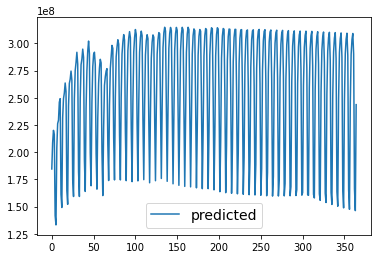

In [631]:
predict_len = 100
plt.plot(pred_hits, label='predicted')
plt.legend(fontsize=14)

Предсказания LSTM с линейным слоем на конце

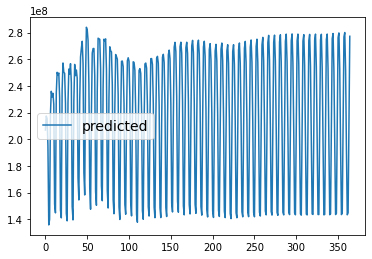

In [275]:
predict_len = 100
plt.plot(pred_hits, label='predicted')
plt.legend(fontsize=14)

Предсказания LSTM с сверточными слоями на конце

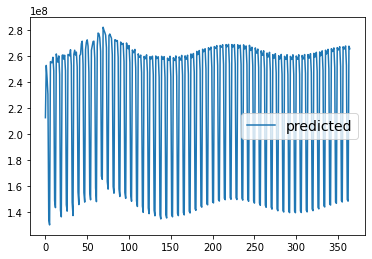

In [717]:
predict_len = 100
plt.plot(pred_hits, label='predicted')
plt.legend(fontsize=14)

## Torch LSTM

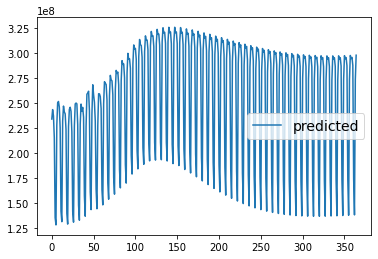

In [336]:
predict_len = 100
plt.plot(pred_hits, label='predicted')
plt.legend(fontsize=14)

CNN with torch.lstm

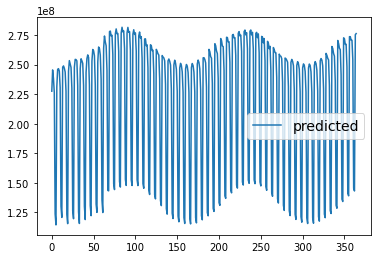

In [1118]:
predict_len = 100
plt.plot(pred_hits, label='predicted')
plt.legend(fontsize=14)

__Пока наилучший результат! 12.1 на тесте__